# 金融数据分析及欺诈检测
by [@梁斌](https://drbinliang.github.io/)<br>
[kaggle项目地址](https://www.kaggle.com/ntnu-testimon/paysim1)<br>
<br>
数据集下载地址<br>
* [kaggle](https://www.kaggle.com/ntnu-testimon/paysim1/downloads/paysim1.zip)

## 数据集描述
该数据集取自某移动支付公司单月的转账日志。对于一条转账记录，预测其是否为欺诈行为。<br><br>
数据列描述：<br>
* step: 对应现实中的时间单位（小时）
* type: 转账类型
* amount: 转账金额
* nameOrig: 转账发起人
* oldbalanceOrg: 转账前发起人账户余额
* newbalanceOrig: 转账后发起人账户余额
* nameDest: 转账收款人
* oldbalanceDest: 转账前收款人账户余额。注意，收款人是商户时（M打头的收款人），没有该信息。
* newbalanceDest: 转账后收款人账户余额。注意，收款人是商户时（M打头的收款人），没有该信息。
* isFraud: 该转账行为是欺诈行为。这里的欺诈行为是指通过掌控客户账户，然后将其金额全部转账到另一个账户，最后全部提现。
* isFlaggedFraud: 商业模型为了控制大额转账并且标记为非法操作。在这里，非法操作是指单笔转账中，转账金额超过200,000。

## 1. 准备阶段

In [5]:
# 加载相关模块和库
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
%matplotlib inline

from sklearn import preprocessing
from scipy.stats import skew, boxcox
import zipfile
import os

In [7]:
# 声明变量
dataset_path = './dataset'
zipfile_path = os.path.join(dataset_path, 'paysim1.zip')
csvfile_path = os.path.join(dataset_path, 'PS_20174392719_1491204439457_log.csv')

# 解压数据集
with zipfile.ZipFile(zipfile_path) as zf:
    zf.extractall(dataset_path)
    
# 读取数据集
raw_data = pd.read_csv(csvfile_path)
# 查看数据集信息
print('数据预览：')
print(raw_data.head())

print('数据统计信息：')
print(raw_data.describe())

print('数据集基本信息：')
print(raw_data.info())

数据预览：
   step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815       170136.0       160296.36   
1     1   PAYMENT   1864.28  C1666544295        21249.0        19384.72   
2     1  TRANSFER    181.00  C1305486145          181.0            0.00   
3     1  CASH_OUT    181.00   C840083671          181.0            0.00   
4     1   PAYMENT  11668.14  C2048537720        41554.0        29885.86   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
0  M1979787155             0.0             0.0        0               0  
1  M2044282225             0.0             0.0        0               0  
2   C553264065             0.0             0.0        1               0  
3    C38997010         21182.0             0.0        1               0  
4  M1230701703             0.0             0.0        0               0  
数据统计信息：
               step        amount  oldbalanceOrg  newbalanceOrig  \
count  6.362620e+06  6.

## 2. 探索性数据分析(EDA)及可视化

转账类型记录统计：
CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: type, dtype: int64


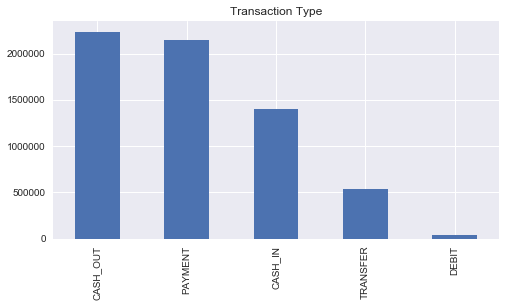

In [11]:
# 查看转账类型
print('转账类型记录统计：')
print(raw_data['type'].value_counts())

fig, ax = plt.subplots(1, 1, figsize=(8, 4))
raw_data['type'].value_counts().plot(kind='bar', title='Transaction Type', ax=ax, figsize=(8, 4))
plt.show()

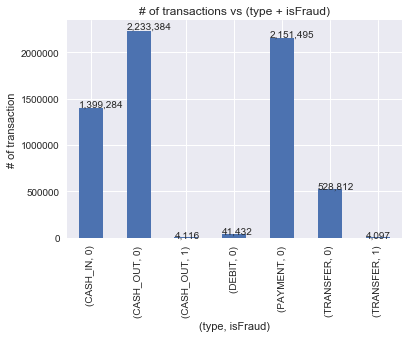

In [16]:
# 查看转账类型和欺诈标记的记录
ax = raw_data.groupby(['type', 'isFraud']).size().plot(kind='bar')
ax.set_title('# of transactions vs (type + isFraud)')
ax.set_xlabel('(type, isFraud)')
ax.set_ylabel('# of transaction')

# 添加标注
for p in ax.patches:
    ax.annotate(str(format(int(p.get_height()), ',d')), (p.get_x(), p.get_height()*1.01))

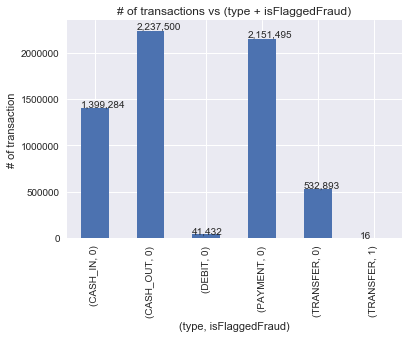

In [17]:
# 查看转账类型和商业模型标记的欺诈记录
ax = raw_data.groupby(['type', 'isFlaggedFraud']).size().plot(kind='bar')
ax.set_title('# of transactions vs (type + isFlaggedFraud)')
ax.set_xlabel('(type, isFlaggedFraud)')
ax.set_ylabel('# of transaction')

# 添加标注
for p in ax.patches:
    ax.annotate(str(format(int(p.get_height()), ',d')), (p.get_x(), p.get_height()*1.01))

通过上面两个图表，可以看出在Transfer类型中，商业模型标记出的“欺诈”记录只有16条，而实际应该有4097条。这个项目的目的就是尽可能准确的预测/检测出欺诈记录。接下来，我们着重分析Transfer类型的记录。

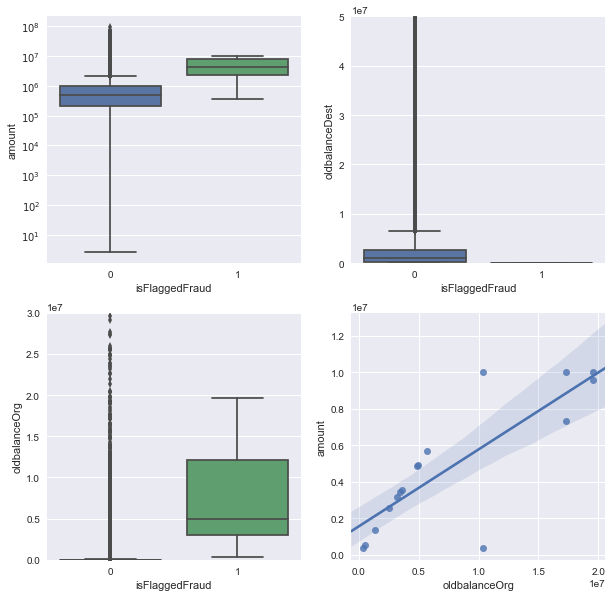

In [24]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
transfer_data = raw_data[raw_data['type'] == 'TRANSFER']

a = sns.boxplot(x='isFlaggedFraud', y='amount', data=transfer_data, ax=axs[0][0])
axs[0][0].set_yscale('log')

b = sns.boxplot(x='isFlaggedFraud', y='oldbalanceDest', data=transfer_data, ax=axs[0][1])
axs[0][1].set(ylim=(0, 0.5e8))

c = sns.boxplot(x='isFlaggedFraud', y='oldbalanceOrg', data=transfer_data, ax=axs[1][0])
axs[1][0].set(ylim=(0, 3e7))

d = sns.regplot(x='oldbalanceOrg', y='amount', data=transfer_data[transfer_data['isFlaggedFraud'] ==1], ax=axs[1][1])
plt.show()


## 3. 数据处理
对CASH_OUT和TRANSFER类型的数据进行处理，因为只有这两类记录存在“欺诈”的数据

In [33]:
used_data = raw_data[(raw_data['type'] == 'TRANSFER') | (raw_data['type'] == 'CASH_OUT')]
# 丢掉不用的数据列
used_data.drop(['step', 'nameOrig', 'nameDest', 'isFlaggedFraud'], axis=1, inplace=True)
# 重新设置索引
used_data = used_data.reset_index(drop=True)

# 将type转换成类别数据，即0, 1
type_label_encoder = preprocessing.LabelEncoder()
type_category = type_label_encoder.fit_transform(used_data['type'].values)
used_data['typeCategory'] = type_category

print(used_data.head())

C:\Program Files\Anaconda2\envs\py35\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


       type     amount  oldbalanceOrg  newbalanceOrig  oldbalanceDest  \
0  TRANSFER     181.00          181.0             0.0             0.0   
1  CASH_OUT     181.00          181.0             0.0         21182.0   
2  CASH_OUT  229133.94        15325.0             0.0          5083.0   
3  TRANSFER  215310.30          705.0             0.0         22425.0   
4  TRANSFER  311685.89        10835.0             0.0          6267.0   

   newbalanceDest  isFraud  typeCategory  
0            0.00        1             1  
1            0.00        1             0  
2        51513.44        0             0  
3            0.00        0             1  
4      2719172.89        0             1  


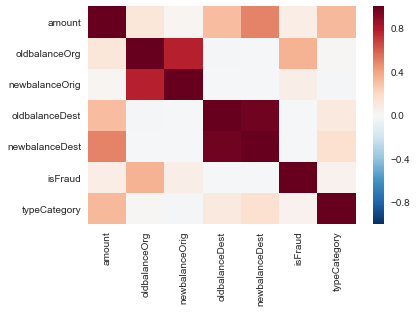

In [35]:
# 查看变量间的相关性
sns.heatmap(used_data.corr())

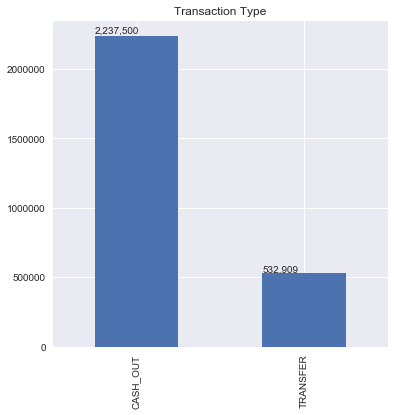

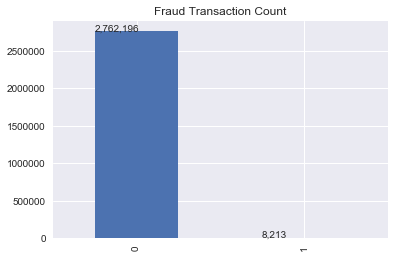

In [39]:
# 查看转账类型记录个数
ax = used_data['type'].value_counts().plot(kind='bar', title="Transaction Type", figsize=(6,6))
for p in ax.patches:
    ax.annotate(str(format(int(p.get_height()), ',d')), (p.get_x(), p.get_height()*1.01))
plt.show()

# 查看转账类型中欺诈记录个数
ax = pd.value_counts(used_data['isFraud'], sort = True).sort_index().plot(kind='bar', title="Fraud Transaction Count")
for p in ax.patches:
    ax.annotate(str(format(int(p.get_height()), ',d')), (p.get_x(), p.get_height()))
plt.show()

In [41]:
# 准备数据
feature_names = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'typeCategory']
X = used_data[feature_names]
y = used_data['isFraud']
print(X.head())
print(y.head())

      amount  oldbalanceOrg  newbalanceOrig  oldbalanceDest  newbalanceDest  \
0     181.00          181.0             0.0             0.0            0.00   
1     181.00          181.0             0.0         21182.0            0.00   
2  229133.94        15325.0             0.0          5083.0        51513.44   
3  215310.30          705.0             0.0         22425.0            0.00   
4  311685.89        10835.0             0.0          6267.0      2719172.89   

   typeCategory  
0             1  
1             0  
2             0  
3             1  
4             1  
0    1
1    1
2    0
3    0
4    0
Name: isFraud, dtype: int64


In [43]:
# 处理不平衡数据
# 欺诈记录的条数
number_records_fraud = len(used_data[used_data['isFraud'] == 1])
# 欺诈记录的索引
fraud_indices = used_data[used_data['isFraud'] == 1].index.values

# 得到非欺诈记录的索引
nonfraud_indices = used_data[used_data['isFraud'] == 0].index

# 随机选取相同数量的非欺诈记录
random_nonfraud_indices = np.random.choice(nonfraud_indices, number_records_fraud, replace=False)
random_nonfraud_indices = np.array(random_nonfraud_indices)

# 整合两类样本的索引
under_sample_indices = np.concatenate([fraud_indices, random_nonfraud_indices])
under_sample_data = used_data.iloc[under_sample_indices, :]
                          
                          
X_undersample = under_sample_data[feature_names].values
y_undersample = under_sample_data['isFraud'].values

# 显示样本比例
print("非欺诈记录比例: ", len(under_sample_data[under_sample_data['isFraud'] == 0]) / len(under_sample_data))
print("欺诈记录比例: ", len(under_sample_data[under_sample_data['isFraud'] == 1]) / len(under_sample_data))
print("欠采样记录数: ", len(under_sample_data))

非欺诈记录比例:  0.5
欺诈记录比例:  0.5
欠采样记录数:  16426


## 4. 数据建模

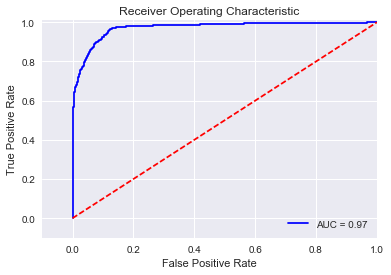

In [46]:
# 选用逻辑回归模型进行预测
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc

# 分割训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X_undersample, y_undersample, test_size=0.3, random_state=0)

lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)

y_pred_score = lr_model.decision_function(X_test)

fpr, tpr, thresholds = roc_curve(y_test, y_pred_score)
roc_auc = auc(fpr,tpr)

# Plot ROC
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.0])
plt.ylim([-0.1,1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## 5. 思考: 如何进一步提升性能
* 特征归一化
* 尝试其他分类预测模型，如决策树、SVM、随机森林等
* 通过交叉验证选取最优的超参数

### 参考资料
1. https://www.kaggle.com/netzone/eda-and-fraud-detection
2. ROC曲线 http://baike.baidu.com/link?url=6HHg6oX1LV-DTKdM07osP_u3chicXhiTV4BklYWvOmOQQPjk9Iay1BYwC_gokmv2onNA6CNy2oCO1Yu02QfuC5zAsXs4rebc2fxVbSliIG_